# Segmentação de imagens

Este exemplo é uma adaptação do tutorial [*Image Segmentation*](http://scikit-image.org/docs/stable/user_guide/tutorial_segmentation.html), parte da documentação oficial do pacote [scikit-image](http://scikit-image.org). Apresenta um exemplo simples de segmentação de imagens, mas bastante útil para ilustrar operações básicas de processamento de imagens e o uso da scikit-image.

**Segmentação de imagens** é a operação de agrupar os pixeis em conjuntos que correspondam a 
*objetos de interesse* que existam na imagem.

In [1]:
import numpy as np

# Importa o módulo de plotagem
import matplotlib.pyplot as plt

# Configura a matplotlib para operar interativamente no notebook.
# Para detalhes, execute: %matplotlib?
%matplotlib inline

# Configura o tamanho padrão da figura largura X altura, em polegadas
plt.rcParams['figure.figsize'] = (10, 4)

Como vimos anteriormente, o módulo `skimage.data` apresenta algumas imagens de teste:

In [2]:
from skimage import data
coins = data.coins()
# Computa o histograma para os valores de níveis de cinza
n_levels = 256
hist, bins = np.histogram(coins, bins=np.arange(n_levels))

(0, 255)

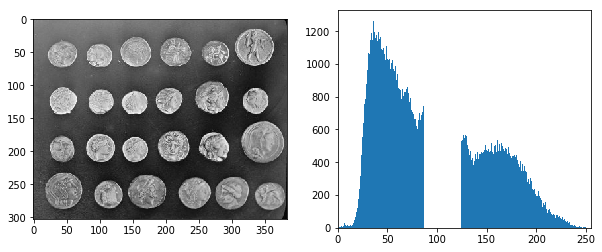

In [3]:
plt.subplot(1,2,1)
plt.imshow(coins, cmap=plt.cm.gray)

plt.subplot(1,2,2)
# Computa o histograma para os valores de níveis de cinza
plt.bar(bins[0:-1], hist)
plt.xlim(0, 255)

Uma alternativa seria segmentar a moedas por **limiarização** (*thresholding*). Infelizmente, nesta imagem, mesmo uma limiarização do tipo *adaptativa* (que encontra o melhor limiar para cada região), não consegue obter um resultados adequado:

In [4]:
from skimage import filters

In [5]:
thresh = filters.threshold_otsu(coins)
binary = coins <= thresh

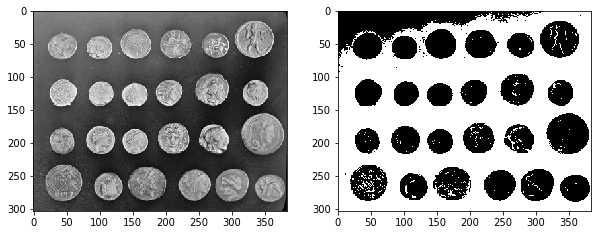

In [6]:
plt.subplot(1,2,1)
plt.imshow(coins, cmap=plt.cm.gray)

plt.subplot(1,2,2)
plt.imshow(binary, cmap=plt.cm.gray)

Uma outra alternativa é encontrar *descontinuidades* ("bordas") na imagem.

## Segmentação baseada em detecção de bordas

Vamos tentar obter as bordas (*edges*) que delimitam as moedas. Para tanto, vamos utilizar o [*detector de bordas de Canny*](https://en.wikipedia.org/wiki/Canny_edge_detector), implementado pela scikit-image em [`skimage.feature.canny`](http://scikit-image.org/docs/stable/api/skimage.feature.html#canny):

In [7]:
from skimage.feature import canny
edges = canny(coins/255.)

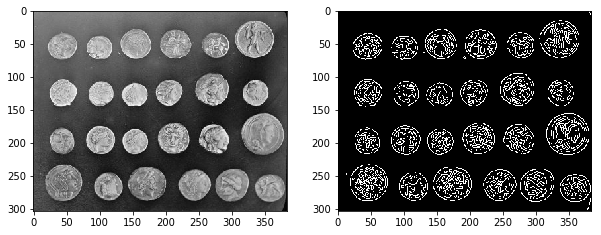

In [8]:
plt.subplot(1,2,1)
plt.imshow(coins, cmap=plt.cm.gray)

plt.subplot(1,2,2)
plt.imshow(edges, cmap=plt.cm.gray)

Devido à homogeneidade do fundo, as bordas surgem nos limites das moedas e dentro das mesmas.

In [9]:
from scipy import ndimage as ndi
fill_coins = ndi.binary_fill_holes(edges)

Com os contornos que delimitam o limite das moedas, preenchemos a parte interna utilizando a função `ndi.binary_fill_holes`, que emprega [*dilatações morfológicas*](https://en.wikipedia.org/wiki/Mathematical_morphology#Dilation) para preencher os buracos:

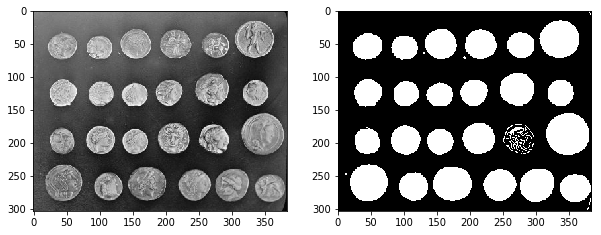

In [10]:
plt.subplot(1,2,1)
plt.imshow(coins, cmap=plt.cm.gray)

plt.subplot(1,2,2)
plt.imshow(fill_coins, cmap=plt.cm.gray)

Pequenos objetos indesejados podem ser removidos facilmente com `remove_small_objects`:

In [11]:
from skimage.morphology import remove_small_objects
coins_cleaned = remove_small_objects(fill_coins, min_size=64)

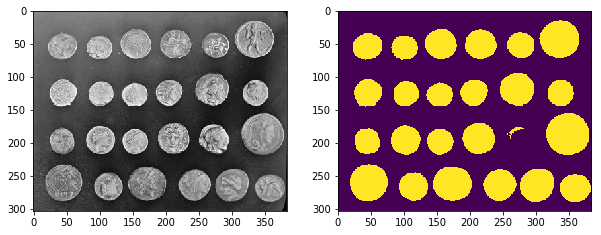

In [12]:
plt.subplot(1,2,1)
plt.imshow(coins, cmap=plt.cm.gray)

plt.subplot(1,2,2)
plt.imshow(coins_cleaned)

A segmentação perdeu uma das moedas, que não foi segmentada corretamente. O motivo é que seu contorno, obtido via *Canny*, não estava completamente fechado e a função de preenchimento não preencheu a parte interna da moeda.

Vamos tentar outra alternativa: trocar um método de segmentação *baseado em bordas* por um método *baseado em regiões*.

## Segmentação baseada em crescimento de regiões

Primeiramente, vamor determinar *marcadores*. Esses marcadores são pixeis que podemos rotular de forma inequívoca como *objeto* ou *plano de fundo* (*background*). Aqui, os marcadores são encontrados nas extremos do histograma:

In [13]:
markers = np.zeros_like(coins)
markers[coins < 30] = 1
markers[coins > 150] = 2

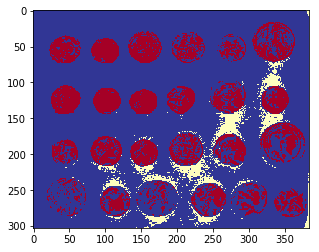

In [14]:
plt.imshow(markers, cmap=plt.cm.RdYlBu_r)

Usaremos esses marcadores em uma segmentação por *watershed* (o algoritmo de "inundação"). Aqui, a imagem em tons de cinza é interpretada como um **relevo**: valores mais altos são *picos* e valores baixos são *vales*. A transformação *watershed* funciona como se os "vales" fossem "inundados". Conforme a água sobe, regiões outrora separadas são unidas. Segmentos formam "bacias", delimitadas pelo encontro das águas. Pense nos marcadores como os locais em que a água começa a subir.

Nosso "relevo" será uma imagem gerada pelo [*filtro de Sobel*](https://en.wikipedia.org/wiki/Sobel_operator), que aproxima o *gradiente* da imagem, apresentando picos nas bordas.

In [15]:
from skimage.filters import sobel
elevation_map = sobel(coins)

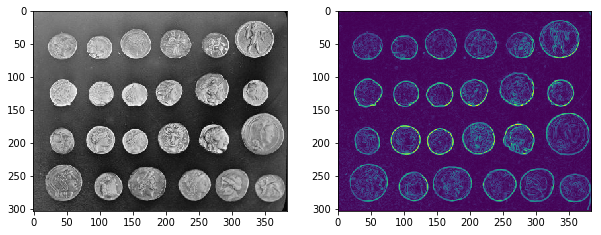

In [16]:
plt.subplot(1,2,1)
plt.imshow(coins, cmap=plt.cm.gray)

plt.subplot(1,2,2)
plt.imshow(elevation_map)

In [17]:
from skimage.morphology import watershed
segmentation = watershed(elevation_map, markers)

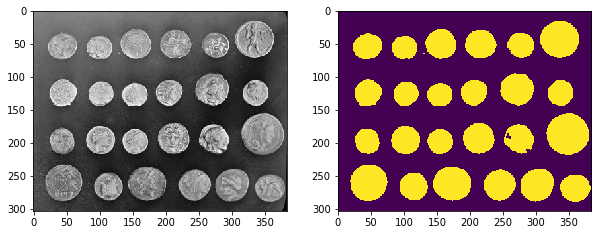

In [18]:
plt.subplot(1,2,1)
plt.imshow(coins, cmap=plt.cm.gray)

plt.subplot(1,2,2)
plt.imshow(segmentation)

In [19]:
segmentation = ndi.binary_fill_holes(segmentation - 1)

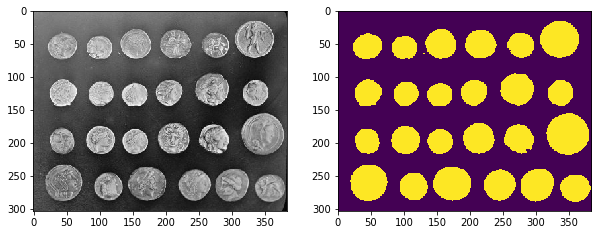

In [20]:
plt.subplot(1,2,1)
plt.imshow(coins, cmap=plt.cm.gray)

plt.subplot(1,2,2)
plt.imshow(segmentation)

In [21]:
segmentation = remove_small_objects(segmentation, min_size=64)

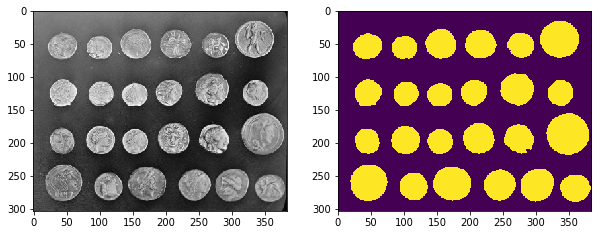

In [22]:
plt.subplot(1,2,1)
plt.imshow(coins, cmap=plt.cm.gray)

plt.subplot(1,2,2)
plt.imshow(segmentation)

A função `ndi.label` rotula a imagem, considerando $0$ como fundo (*background*) e contando regiões contíguas de pixeis apresentando o mesmo valor, atribuindo a cada região um *rótulo* que segue uma contagem de regiões:

In [23]:
labeled_coins, _ = ndi.label(segmentation)

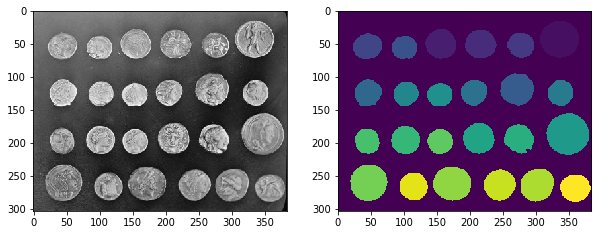

In [24]:
plt.subplot(1,2,1)
plt.imshow(coins, cmap=plt.cm.gray)

plt.subplot(1,2,2)
plt.imshow(labeled_coins)

A função `np.unique` devolve os valores observados em um array:

In [25]:
np.unique(labeled_coins)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24], dtype=int32)

Temos então 25 valores diferentes. Como um deles corresponde ao _background_, temos então **24 moedas** na imagem.

In [26]:
labeled_coins.max()

24

Para visualizarmos claramente os **limites** de cada segmento, vamos subtrair a imagem binária da segmentação de uma versão dilatada dela mesma:

In [27]:
from skimage.morphology import erosion, square

In [28]:
binary_coins = np.zeros_like(labeled_coins)
binary_coins[labeled_coins > 0] = 255
border = binary_coins - erosion(binary_coins, square(5))

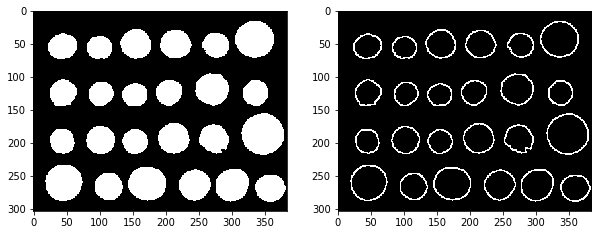

In [29]:
plt.subplot(1,2,1)
plt.imshow(binary_coins, cmap=plt.cm.gray)

plt.subplot(1,2,2)
plt.imshow(border, cmap=plt.cm.binary_r)

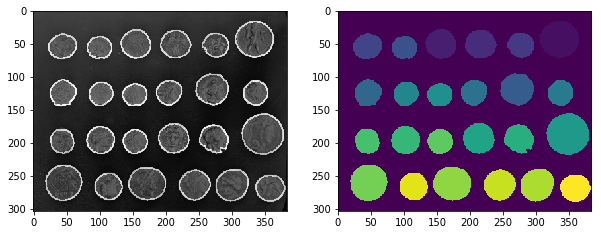

In [30]:
plt.subplot(1,2,1)
plt.imshow(coins, cmap=plt.cm.gray)
plt.imshow(border, cmap=plt.cm.binary_r, alpha=0.5)

plt.subplot(1,2,2)
plt.imshow(labeled_coins)